In [1]:
using Plots, LinearAlgebra, MeshCat, ColorTypes
using DelimitedFiles,  FileIO, Images
using GeometryBasics
using CoordinateTransformations, Quaternions
using Interpolations

[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]


In [2]:
function quat_to_rot(q::Quaternion)
    q0 = q.s
    q1 = q.v1
    q2 = q.v2
    q3 = q.v3
    
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = [[r00;; r01;; r02];
                           [r10;; r11;; r12];
                           [r20;; r21;; r22]]
    return rot_matrix
end

quat_to_rot (generic function with 1 method)

In [3]:
function tf_to_pose(tx, ty, tz, qx, qy, qz, qw)
    t = [tx, ty, tz]
    q = Quaternion(qw, qx, qy, qz)
    R = quat_to_rot(q)
    
    T = [[R ;; t] ; [zeros(1,3) ;; 1]]
    
    return T
end

function create_interpolator(ground_truth_matrix)
    tfs = [ground_truth_matrix[i,2:end] for i=1:size(ground_truth_matrix, 1)];
    itp = LinearInterpolation(ground_truth_matrix[:,1], tfs);
    
    function get_pose(t)
        tf = itp(t)
        T = tf_to_pose(tf...)
        return T
    end
end

function depth_to_dist(dimg; factor=5000.0)
    return reshape([Int(dimg[k].val.i)/factor for k in eachindex(dimg)], size(dimg))
end

function camera_intrinsic_matrix(fx, fy, cx, cy)
    K = [[fx;; 0 ;; cx;; 0] ; [0 ;; fy ;; cy;; 0] ; [0 0 1 0] ; [0 0 0 1]]
    return K
end

function dist_to_pc(dimg, inv_camera_intrinsic)
    
    N = length(dimg)
    
    UVZ = ones(4, N)
    
    for (i, p) in enumerate(CartesianIndices(dimg))
        z = dimg[p]
        
        UVZ[1,i] = z * p[2]
        UVZ[2,i] = z * p[1]
        UVZ[3,i] = z
    end
    
    PC = inv_camera_intrinsic * UVZ
        
    return PC
end

function pc_mat_to_mesh(pc_mat)
    pts = Set{Point{3, Float32}}()
    for i in 1:size(pc_mat, 2)
        if pc_mat[1:3, i] != [0,0,0.]
            push!(pts, Point3f(pc_mat[:,i]))
        end
    end
    return pts
end

function depth_ind_to_pc_world(depth_ind, data_folder, depth_filenames,  camera_matrix, get_pose)
    
    dist_img = load(joinpath(data_folder, depth_filenames[depth_ind,2]))
    
    depth_img = depth_to_dist(dist_img)
    
    pc_camera = dist_to_pc(depth_img, inv(camera_matrix))
    
    T = get_pose(depth_filenames[depth_ind,1])
    
    pc_world = T *  pc_camera
    
    return pc_world
end

depth_ind_to_pc_world (generic function with 1 method)

## Define Data Folder

In [4]:
data_folder = joinpath(pwd(), "data/mannequin_1")

"/Users/devanshagrawal/research/7_2022_fall/point_cloud_registration/data/mannequin_1"

### Load calib matrix

In [5]:
calib = readdlm(joinpath(data_folder, "calibration.txt"))

1×4 Matrix{Float64}:
 726.287  726.287  354.65  186.466

In [6]:
K = camera_intrinsic_matrix(calib...)

4×4 Matrix{Float64}:
 726.287    0.0    354.65   0.0
   0.0    726.287  186.466  0.0
   0.0      0.0      1.0    0.0
   0.0      0.0      0.0    1.0

### Load the ground truth

In [7]:
ground_truth = readdlm(joinpath(data_folder, "groundtruth.txt"), skipstart=1);

In [8]:
get_pose = create_interpolator(ground_truth)

get_pose (generic function with 1 method)

In [9]:
get_pose(11199.05)

4×4 Matrix{Float64}:
  0.195795  -0.800756    0.566086  -0.200512
 -0.975419  -0.0995145   0.196606  -1.0343
 -0.1011    -0.590666   -0.800558   1.24627
  0.0        0.0         0.0        1.0

### Load depth images

In [10]:
depth_filenames = readdlm(joinpath(data_folder, "depth.txt"));

In [11]:
depth_ts = depth_filenames[:,1]

643-element Vector{Any}:
 11197.086112976
 11197.122976542
 11197.159839869
 11197.196702957
 11197.233566523
 11197.27042985
 11197.307293415
 11197.344156742
 11197.381020069
 11197.417883396
 11197.454746723
 11197.49161005
 11197.528473616
     ⋮
 11220.346900225
 11220.383763552
 11220.420626879
 11220.457490444
 11220.494353533
 11220.53121686
 11220.568080425
 11220.604943752
 11220.641807318
 11220.678670645
 11220.715533733
 11220.752397299

[ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]


,,,,

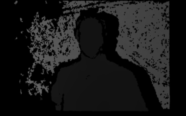
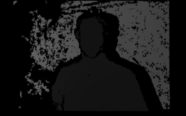
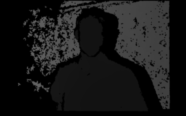
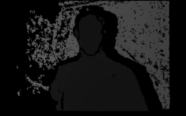
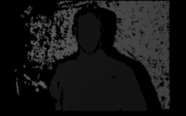

In [12]:
dimgs = [load(joinpath(data_folder, depth_filenames[i,2])) for i=1:5]

In [13]:
dist_imgs = [depth_to_dist(dimg) for dimg in dimgs]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

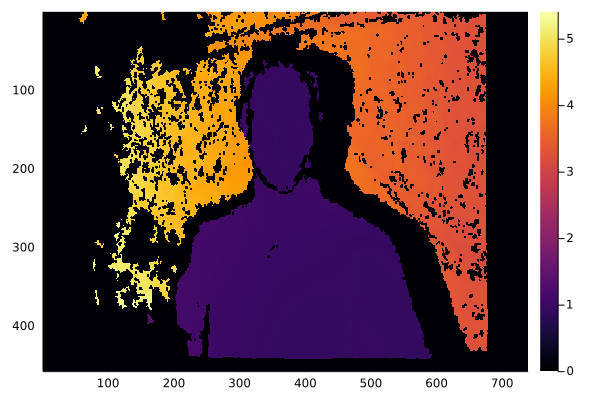

In [14]:
heatmap(dist_imgs[1]; yflip=true)

In [15]:
dist_imgs[1]

458×739 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
maximum(dist_imgs[1])

5.4112

In [41]:
## Convert to pointcloud

In [42]:
invK = inv(K)
@time pc1 = dist_to_pc(dist_imgs[1], invK)


  0.015046 seconds (4 allocations: 20.658 MiB)


4×338462 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [19]:
pc4 = dist_to_pc(dist_imgs[4], invK)

4×338462 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [20]:
pc1_world = get_pose(depth_ts[1]) * pc1

4×338462 Matrix{Float64}:
 -0.27991  -0.27991  -0.27991  -0.27991  …  -0.27991  -0.27991  -0.27991
 -1.16457  -1.16457  -1.16457  -1.16457     -1.16457  -1.16457  -1.16457
  1.70494   1.70494   1.70494   1.70494      1.70494   1.70494   1.70494
  1.0       1.0       1.0       1.0          1.0       1.0       1.0

In [21]:
pc4_world = get_pose(depth_ts[4]) * pc4

4×338462 Matrix{Float64}:
 -0.293581  -0.293581  -0.293581  …  -0.293581  -0.293581  -0.293581
 -1.15682   -1.15682   -1.15682      -1.15682   -1.15682   -1.15682
  1.70721    1.70721    1.70721       1.70721    1.70721    1.70721
  1.0        1.0        1.0           1.0        1.0        1.0

In [22]:
pts1_camera = pc_mat_to_mesh(pc1);
pts1_world = pc_mat_to_mesh(pc1_world);

In [23]:
pts4_world = pc_mat_to_mesh(pc4_world);

In [24]:
colors1 = [RGB(1,0,0) for p in pts1_world];
colors4 = [RGB(0,1,0) for p in pts4_world];

In [25]:
setobject!(vis, PointCloud(pts1_world, colors))

LoadError: UndefVarError: colors not defined

In [26]:
colors = [RGB(0,1,0) for p in pts4_world];

In [27]:
pts = union(pts1_world, pts4_world) |> collect

330437-element Vector{Point{3, Float32}}:
 [0.55944574, -0.6098171, 1.627061]
 [0.5446741, -0.7250755, 1.4997288]
 [0.48944825, -0.5817379, 1.4298221]
 [0.546946, -0.73644793, 1.4919683]
 [3.2343771, 0.06846897, 1.3624568]
 [0.5331186, -0.6594339, 1.5257345]
 [3.1651204, -0.43029612, 1.5766104]
 [3.2412055, 1.4291905, 2.3455598]
 [0.6210167, -0.9089848, 1.3942877]
 [3.1453655, 2.2080805, 1.8117981]
 [0.59104776, -0.8410723, 1.4025677]
 [3.193085, -0.38832182, 1.3238852]
 [0.54036844, -0.62086076, 1.5387412]
 ⋮
 [3.225189, -0.062165372, 2.0499682]
 [3.15766, -0.3112504, 1.2767744]
 [3.2296894, -0.5751004, 1.9737407]
 [0.49283093, -0.65642655, 1.7490352]
 [0.5905789, -0.5153065, 1.5830456]
 [0.5525003, -0.6268209, 1.5506175]
 [3.234047, -0.6663243, 1.7773582]
 [0.5690042, -0.7970985, 1.3682349]
 [0.49927366, -0.6457821, 1.7925315]
 [3.1511028, -0.5881261, 0.62204766]
 [3.2352076, -0.08641882, 2.0043275]
 [0.5161672, -0.71451247, 1.8064548]

In [28]:
cols = cat(colors1, colors4, dims=1);

In [29]:
vis = Visualizer()

IJuliaCell(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [30]:
pts_world_i = [depth_ind_to_pc_world(i, data_folder, depth_filenames, K, get_pose) for i=1:25:650];

In [31]:
pc_mesh_i = [collect(pc_mat_to_mesh(p)) for p in pts_world_i];

In [32]:
col0_s = [RGB(1,0,0) , RGB(0,1,0), RGB(1,1,0.1), RGB(0,1,1)]

In [33]:
typeof(RGB(0,0,0))

RGB{N0f8}

In [34]:
cols = [fill(col0_s[mod(i, length(col0_s))+1], length(pc_mesh_i[i])) for i=1:length(pc_mesh_i)];

In [35]:
all_pts = Point3f[]
all_cols = RGB{N0f8}[]
for i in 1:10:650
    pc_world = depth_ind_to_pc_world(i, data_folder, depth_filenames, K, get_pose)
    N = size(pc_world, 2)
    inds = rand(1:N, Int(round(0.01*N)))
    pc_mesh = collect(pc_mat_to_mesh(pc_world[:,inds]))
    push!(all_pts, pc_mesh...)
    push!(all_cols, fill(col0_s[mod(i, length(col0_s)) + 1], length(pc_mesh))...)
end
    
    
    
#     for j in inds
#         push!(all_pts, pc_mesh[j])
#         push!(all_cols, col0_s[mod(i, length(col0_s)) + 1])
#     end
#end

In [36]:
setobject!(vis, PointCloud(all_pts, all_cols))

MeshCat Visualizer with path /meshcat at http://127.0.0.1:8700